# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
from scipy import stats as st


## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
df_plans = pd.read_csv('/datasets/megaline_plans.csv')
df_users = pd.read_csv('/datasets/megaline_users.csv')
df_calls = pd.read_csv('/datasets/megaline_calls.csv')
df_messages = pd.read_csv('/datasets/megaline_messages.csv')
df_internet = pd.read_csv('/datasets/megaline_internet.csv')

## Preparar los datos

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
df_plans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas

df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Corregir datos

Para el DataFrame plans se cambio el encabezado de "mb_per_month_included" por "gb_per_month_included" debido que los datos en MB serán redondeados a GB.

## Enriquecer los datos

In [5]:
# Cambiar el nombre del encabezado "mb_per_month_included"

new_col_names = []

for change in df_plans.columns:
    #reemplaza el mb_per_month_included por 'gb_per_month_included'
    new_string = change.replace('mb_per_month_included','gb_per_month_included')
    # Agrega el nuevo nombre a la lista de nuevos nombres de columna
    new_col_names.append(new_string)

# Reemplaza los nombres anteriores por los nuevos

df_plans.columns = new_col_names

print(df_plans.columns)

Index(['messages_included', 'gb_per_month_included', 'minutes_included',
       'usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute',
       'plan_name'],
      dtype='object')


In [6]:
df_plans.head()
df_plans['gb_per_month_included'] = df_plans['gb_per_month_included']/1024
df_plans['gb_per_month_included']=np.ceil(df_plans['gb_per_month_included'])
df_plans

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


## Usuarios/as

In [7]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
# Imprime una muestra de datos para usuarios
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN




A contiunación, se observa que el Dataframe contiene valores ausentes en la columna "churn_date" y fue reemplazado con valores 0, tambien la columna "reg_date" fue convertido a datetime.

### Corregir los datos

In [9]:
columns_to_replace = ['churn_date']

for col in columns_to_replace:
    df_users[col].fillna(0, inplace=True)
    
print(df_users.isna().sum())

user_id       0
first_name    0
last_name     0
age           0
city          0
reg_date      0
plan          0
churn_date    0
dtype: int64


### Enriquecer los datos

In [10]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
df_users

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,0
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,0
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,0
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,0
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,0
...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,0
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,0
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,0
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,0


## Llamadas

In [11]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [12]:
# Imprime una muestra de datos para las llamadas
df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22




En el DataFrame Calls, logramos visualizar 4 columnas y la columna "duration" será redondeado a minutos y de igual manera "call_date" es transformado a datetime.

### Corregir los datos

In [13]:
df_calls["duration"]=np.ceil(df_calls["duration"])
df_calls

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9.0
1,1000_145,1000,2018-12-27,14.0
2,1000_247,1000,2018-12-27,15.0
3,1000_309,1000,2018-12-28,6.0
4,1000_380,1000,2018-12-30,5.0
...,...,...,...,...
137730,1499_199,1499,2018-11-21,9.0
137731,1499_200,1499,2018-10-20,11.0
137732,1499_201,1499,2018-09-21,9.0
137733,1499_202,1499,2018-10-10,1.0


### Enriquecer los datos

In [14]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_calls

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9.0
1,1000_145,1000,2018-12-27,14.0
2,1000_247,1000,2018-12-27,15.0
3,1000_309,1000,2018-12-28,6.0
4,1000_380,1000,2018-12-30,5.0
...,...,...,...,...
137730,1499_199,1499,2018-11-21,9.0
137731,1499_200,1499,2018-10-20,11.0
137732,1499_201,1499,2018-09-21,9.0
137733,1499_202,1499,2018-10-10,1.0


## Mensajes

In [15]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [16]:
# Imprime una muestra de datos para los mensajes
df_messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26




Para el DataFrame mesages, se logra observar que tiene una relación con el DataFrame User y en este caso la columa "message_date" es transformado a datetime para facilitar filtrar la información requerida.

### Corregir los datos

In [17]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_messages

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
...,...,...,...
76046,1497_526,1497,2018-12-24
76047,1497_536,1497,2018-12-24
76048,1497_547,1497,2018-12-31
76049,1497_558,1497,2018-12-24


### Enriquecer los datos

## Internet

In [18]:
# Imprime la información general/resumida sobre el DataFrame de internet
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [19]:
# Imprime una muestra de datos para el tráfico de internet
df_internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22




Se puede observar que el DataFrame contiene 4 columnas y de igual forma está relacionado siepre con la tabla user. Para la columna "mb_used" la información está en MB y los requisitos es que sean transformados a GB y tambien la columna "session_date" es convertido en el tipo de dato datetime y por último es redondeado.

### Corregir los datos

### Enriquecer los datos

In [20]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])
df_internet

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06
104821,1499_216,1499,2018-12-30,304.72
104822,1499_217,1499,2018-09-22,292.75
104823,1499_218,1499,2018-12-07,0.00


## Estudiar las condiciones de las tarifas

In [21]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
df_plans.head()

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


## Agregar datos por usuario


In [22]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
df_calls['month'] = df_calls['call_date'].dt.month
llamadas_usuarios = df_calls.groupby(['user_id', 'month'])['id'].count().reset_index(name='num_call')
llamadas_usuarios


,user_id,month,num_call
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


In [23]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
minutos_usuarios = df_calls.groupby(['user_id', 'month'])['duration'].sum().reset_index(name= 'total_minutes')
minutos_usuarios.sort_values(by= 'user_id')


,user_id,month,total_minutes
0,1000,12,124.0
1,1001,8,182.0
2,1001,9,315.0
3,1001,10,393.0
4,1001,11,426.0
...,...,...,...
2247,1498,6,238.0
2255,1499,10,385.0
2256,1499,11,308.0
2254,1499,9,346.0


In [24]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
df_messages['month'] = df_messages['message_date'].dt.month
num_msj = df_messages.groupby(['user_id', 'month'])['id'].count().reset_index(name='num_messages')
num_msj


,user_id,month,num_messages
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [25]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
df_internet['month'] = df_internet['session_date'].dt.month
vol_datos= df_internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()

vol_datos.rename(columns={'mb_used':'gb_used'},inplace=True)
vol_datos['gb_used']=np.ceil(vol_datos['gb_used']/1024) 
vol_datos


,user_id,month,gb_used
0,1000,12,2.0
1,1001,8,7.0
2,1001,9,14.0
3,1001,10,22.0
4,1001,11,19.0
...,...,...,...
2272,1498,12,23.0
2273,1499,9,13.0
2274,1499,10,20.0
2275,1499,11,17.0


In [26]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
fusion= pd.merge(llamadas_usuarios, minutos_usuarios, how= 'outer', on= ['user_id', 'month'])
fusion_1= pd.merge(fusion, num_msj, how= 'outer', on= ['user_id', 'month'])
fusion_2= pd.merge(fusion_1, vol_datos, how='outer', on=['user_id', 'month'])
df_merged = pd.merge(fusion_2, df_users[['user_id','city', 'plan']], how='outer', on=['user_id'])
df_merged .rename(columns={'plan':'plan_name'},inplace=True)

#Reemplazo de ceros en los valores nulos.
columns_to_replace = ['num_call', 'total_minutes', 'num_messages', 'gb_used']

for col in columns_to_replace:
    df_merged[col].fillna(0, inplace=True)
    
df_merged.isna().sum()
df_merged

,user_id,month,num_call,total_minutes,num_messages,gb_used,city,plan_name
0,1000,12.0,16.0,124.0,11.0,2.0,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate
1,1001,8.0,27.0,182.0,30.0,7.0,"Seattle-Tacoma-Bellevue, WA MSA",surf
2,1001,9.0,49.0,315.0,44.0,14.0,"Seattle-Tacoma-Bellevue, WA MSA",surf
3,1001,10.0,65.0,393.0,53.0,22.0,"Seattle-Tacoma-Bellevue, WA MSA",surf
4,1001,11.0,64.0,426.0,36.0,19.0,"Seattle-Tacoma-Bellevue, WA MSA",surf
...,...,...,...,...,...,...,...,...
2298,1307,NaN,0.0,0.0,0.0,0.0,"Boston-Cambridge-Newton, MA-NH MSA",surf
2299,1319,NaN,0.0,0.0,0.0,0.0,"Colorado Springs, CO MSA",surf
2300,1378,NaN,0.0,0.0,0.0,0.0,"Denver-Aurora-Lakewood, CO MSA",surf
2301,1463,NaN,0.0,0.0,0.0,0.0,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate


In [27]:
# Añade la información de la tarifa
df_plans.head()


,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


In [29]:
# Calcula el ingreso mensual para cada usuario
montly_income = df_merged.merge(df_plans, on='plan_name', how='outer')

def minuto(row):
    if row['total_minutes'] <=3000 and row['plan_name'] == 'ultimate':
        return 3000

    elif row['total_minutes'] <=500 and row['plan_name'] == 'surf':
        return 500
    else:
        return row['total_minutes']


def mensaje(row):
    if row['num_messages'] <=1000 and row['plan_name'] == 'ultimate':
        return 1000
    elif row['num_messages']<=50 and row['plan_name'] == 'surf':
        return 50
    else:
        return row['num_messages']
    
    

def giga(row):
    if row['gb_used'] <=30 and row['plan_name'] == 'ultimate':
        return 30
    elif row['gb_used'] <=15 and row['plan_name'] == 'surf':
        return 15
    else:
        return row['gb_used']
    

    
montly_income['total_minutes']= montly_income.apply(minuto,axis=1)
montly_income['num_messages']= montly_income.apply(mensaje,axis=1)
montly_income['gb_used']= montly_income.apply(giga,axis=1)

                                                             
montly_income['pay_client']= ((montly_income['total_minutes']- montly_income['minutes_included'])* (montly_income["usd_per_minute"]))+ ((montly_income['num_messages']- montly_income['messages_included'])* (montly_income['usd_per_message']))+ ((montly_income['gb_used']- montly_income['gb_per_month_included'])* (montly_income['usd_per_gb']))+ montly_income['usd_monthly_pay']
montly_income

,user_id,month,num_call,total_minutes,num_messages,gb_used,city,plan_name,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,pay_client
0,1000,12.0,16.0,3000.0,1000.0,30.0,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,1000,30.0,3000,70,7,0.01,0.01,70.0
1,1006,11.0,2.0,3000.0,1000.0,30.0,"San Francisco-Oakland-Berkeley, CA MSA",ultimate,1000,30.0,3000,70,7,0.01,0.01,70.0
2,1006,12.0,9.0,3000.0,1000.0,32.0,"San Francisco-Oakland-Berkeley, CA MSA",ultimate,1000,30.0,3000,70,7,0.01,0.01,84.0
3,1008,10.0,71.0,3000.0,1000.0,30.0,"Orlando-Kissimmee-Sanford, FL MSA",ultimate,1000,30.0,3000,70,7,0.01,0.01,70.0
4,1008,11.0,63.0,3000.0,1000.0,30.0,"Orlando-Kissimmee-Sanford, FL MSA",ultimate,1000,30.0,3000,70,7,0.01,0.01,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1143,NaN,0.0,500.0,50.0,15.0,"Cincinnati, OH-KY-IN MSA",surf,50,15.0,500,20,10,0.03,0.03,20.0
2299,1307,NaN,0.0,500.0,50.0,15.0,"Boston-Cambridge-Newton, MA-NH MSA",surf,50,15.0,500,20,10,0.03,0.03,20.0
2300,1319,NaN,0.0,500.0,50.0,15.0,"Colorado Springs, CO MSA",surf,50,15.0,500,20,10,0.03,0.03,20.0
2301,1378,NaN,0.0,500.0,50.0,15.0,"Denver-Aurora-Lakewood, CO MSA",surf,50,15.0,500,20,10,0.03,0.03,20.0


## Estudia el comportamiento de usuario

### Llamadas

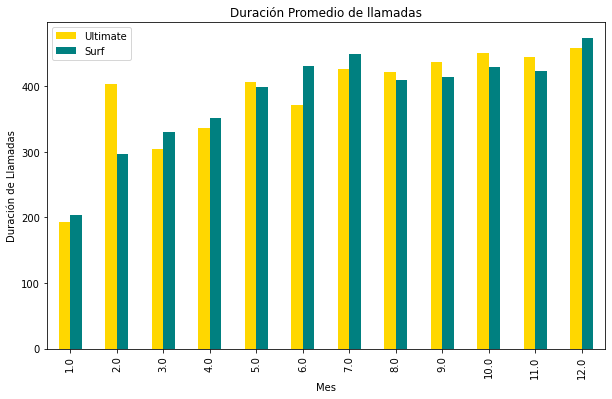

In [29]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
ultima = df_merged[df_merged['plan_name'] == 'ultimate'].groupby('month')['total_minutes'].mean()
navegar = df_merged[df_merged['plan_name'] == 'surf'].groupby('month')['total_minutes'].mean()
df_promedio = pd.concat([ultima,navegar],axis= 'columns')
df_promedio.columns = ['Ultimate', 'Surf']

ax = df_promedio.plot(kind='bar', figsize=(10, 6), color=['gold', 'teal'])
plt.title('Duración Promedio de llamadas')
plt.ylabel('Duración de Llamadas')
plt.xlabel('Mes')

plt.show()


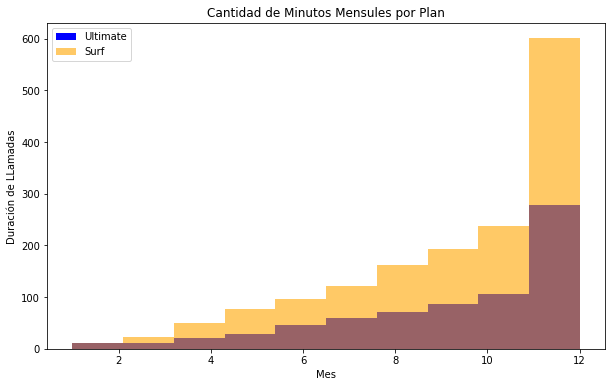

In [30]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
df_ultimo = df_merged[df_merged['plan_name'] == 'ultimate']['month'].plot(kind='hist', color= 'blue', figsize= [10,6])
df_navegar = df_merged[df_merged['plan_name'] == 'surf']['month'].plot(kind='hist', color= 'orange', alpha=0.6)

plt.ylabel('Duración de LLamadas')
plt.xlabel('Mes')
plt.title('Cantidad de Minutos Mensules por Plan')
plt.legend(['Ultimate', 'Surf'])

plt.show()


In [31]:
# Calcula la media y la varianza de la duración mensual de llamadas.
df_ultimo_first = df_merged[df_merged['plan_name'] == 'ultimate']['month'].mean()
df_ultimo_second = df_merged[df_merged['plan_name'] == 'ultimate']['month'].var()

df_navegar_first = df_merged[df_merged['plan_name'] == 'surf']['month'].mean()
df_navegar_second = df_merged[df_merged['plan_name'] == 'surf']['month'].var()

print('La Media del plan ULTIMATE es: ', df_ultimo_first)
print('La Media del plan SURF es: ', df_navegar_first)
print()
print('La Varianza del plan ULTIMATE es: ', df_ultimo_second)
print('La Varinza del plan SURF es: ', df_navegar_second)


La Media del plan ULTIMATE es:  9.151388888888889
La Media del plan SURF es:  9.182453909726638

La Varianza del plan ULTIMATE es:  6.545895147581519
La Varinza del plan SURF es:  6.092007460501562


<AxesSubplot:title={'center':'total_minutes'}, xlabel='plan_name'>

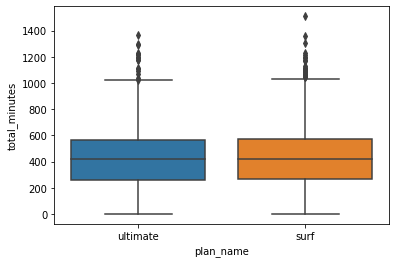

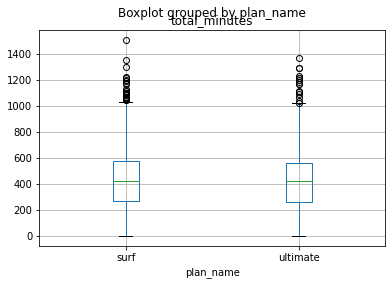

In [32]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
sns.boxplot(data= df_merged, x= 'plan_name',y= 'total_minutes')
df_merged.boxplot(column= "total_minutes", by= 'plan_name')


In [33]:
df_merged.groupby('plan_name')['total_minutes'].describe()


,count,mean,std,min,25%,50%,75%,max
plan_name,,,,,,,,
surf,1579.0,427.120329,235.490079,0.0,269.00,424.0,576.00,1510.0
ultimate,724.0,428.071823,241.958423,0.0,258.75,421.5,564.25,1369.0


Con base a la información analizada, se puede observar que la media y la varianza en ambos planes casi son similares, la cual indica que el plan SURF es el consume mas minutos a comparación del plan ULTIMATE, al mismo tiempo se puede observar la duración promedio de llamadas  que la diferencia es minima entre ambos ´planes.

### Mensajes

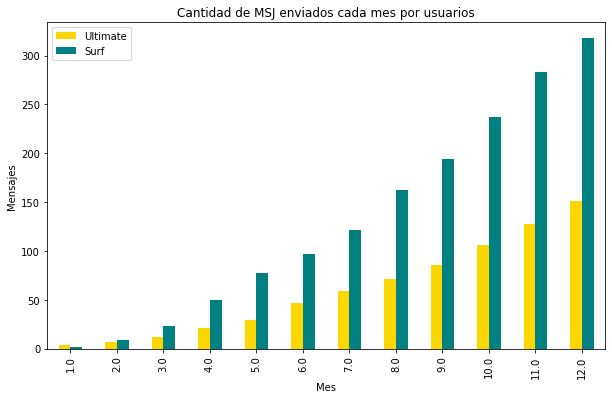

In [34]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
df_ultimo_msj = df_merged[df_merged['plan_name'] == 'ultimate'].groupby('month')['num_messages'].count()
df_navegar_msj = df_merged[df_merged['plan_name'] == 'surf'].groupby('month')['num_messages'].count()

df_msj = pd.concat([df_ultimo_msj ,df_navegar_msj],axis= 'columns')
df_msj.columns = ['Ultimate', 'Surf']


ax = df_msj.plot(kind='bar', figsize=(10, 6), color=['gold', 'teal'])
plt.title('Cantidad de MSJ enviados cada mes por usuarios')
plt.ylabel('Mensajes')
plt.xlabel('Mes')

plt.show()


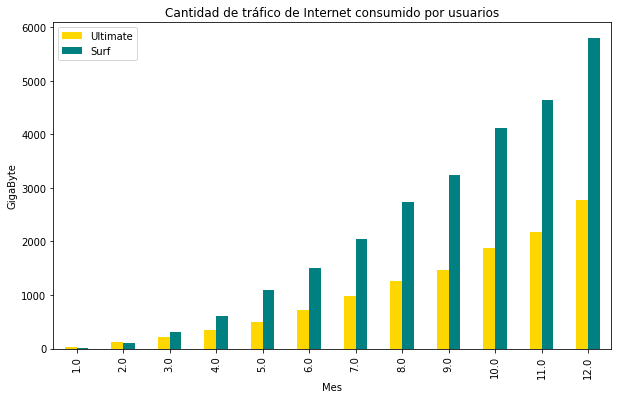

In [35]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
df_ultimo_internet = df_merged[df_merged['plan_name'] == 'ultimate'].groupby('month')['gb_used'].sum()
df_navegar_internet = df_merged[df_merged['plan_name'] == 'surf'].groupby('month')['gb_used'].sum()

df_internet = pd.concat([df_ultimo_internet, df_navegar_internet],axis= 'columns')
df_internet.columns = ['Ultimate', 'Surf']


ax = df_internet.plot(kind='bar', figsize=(10, 6), color=['gold', 'teal'])
plt.title('Cantidad de tráfico de Internet consumido por usuarios')
plt.ylabel("GigaByte")
plt.xlabel("Mes")

plt.show()


<AxesSubplot:xlabel='plan_name', ylabel='gb_used'>

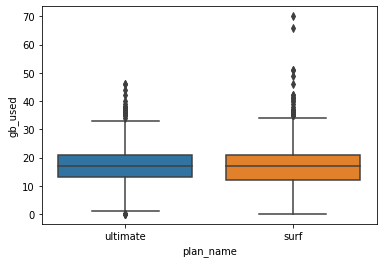

In [36]:
sns.boxplot(data=df_merged, x= 'plan_name', y= 'gb_used')




Con base la información botenida, se puede visualizar en la gráfica que el comportamiento de los usuarios con respecto a los mensajes, es que los usuarios de mas consumo en mensajes son los que pertenecen al plan SURF.

### Internet

In [37]:
internet_ultimo = montly_income[montly_income['plan_name'] == 'ultimate']['gb_used'].mean()
internet_navegar = montly_income[montly_income['plan_name'] == 'surf']['gb_used'].mean()

In [38]:
print('Promedio de Internet del Plan ULTIMATE es: ', internet_ultimo)


Promedio de Internet del Plan ULTIMATE es:  30.328729281767956


In [39]:
print('Promedio de Internet del Plan SURF es: ', internet_navegar)


Promedio de Internet del Plan SURF es:  18.850538315389485



Según se observa en la gráfica, los usuarios tienden a consumir el tráfico de internet con base a su comportamineto de su plan. En este caso se puede afirmar con certeza que los usuarios SURF consumen más datos a comparación de los otros usuarios ULTIMATE.

## Ingreso

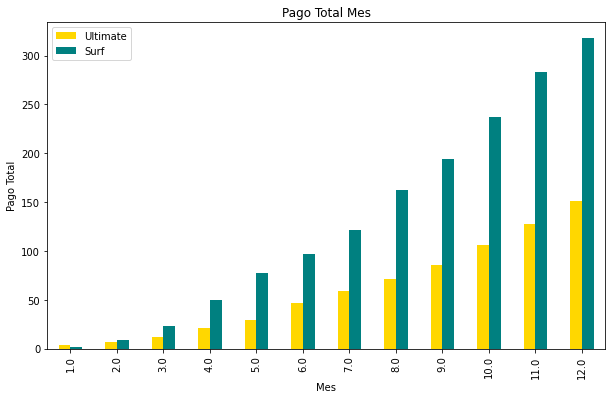

In [40]:
pago_ultimo = montly_income[montly_income['plan_name'] == 'ultimate'].groupby('month')['pay_client'].sum()
pago_navegar = montly_income[montly_income['plan_name'] == 'surf'].groupby('month')['month'].sum()

df_pago = pd.concat([pago_ultimo, pago_navegar],axis= 'columns')
df_pago.columns = ['Ultimate', 'Surf']

ax = df_msj.plot(kind='bar', figsize=(10, 6), color=['gold', 'teal'])
plt.title('Pago Total Mes')
plt.ylabel('Pago Total')
plt.xlabel('Mes')

plt.show()

In [41]:
ingreso_plan_ultimo = montly_income[montly_income['plan_name'] == 'ultimate']['pay_client'].mean()
ingreso_plan_navegar = montly_income[montly_income['plan_name'] == 'surf']['pay_client'].mean()

In [42]:
print('El ingreso del Plan SURF es: ',ingreso_plan_navegar)

El ingreso del Plan SURF es:  60.551728942368584


In [43]:
print('El ingreso del Plan ULTIMATE es: ',ingreso_plan_ultimo)

El ingreso del Plan ULTIMATE es:  72.3011049723757


In [44]:
montly_income.groupby('plan_name')['pay_client'].describe()

,count,mean,std,min,25%,50%,75%,max
plan_name,,,,,,,,
surf,1579.0,60.551729,55.339379,20.0,20.0,40.18,80.315,590.37
ultimate,724.0,72.301105,11.364839,70.0,70.0,70.00,70.000,182.00




Con base la información recolectada y analizada, se puede observar en la gráfica estadística que el plan con mayor ingreso es el SURF y de esta manera se logra determinar que es el plan mas rentable para la empresa.

## Prueba las hipótesis estadísticas

Para desarrollar la hipótesis fue necesario la aplicación de herramienta estadística inferencial. Para este caso fue necesario el uso de la st.levene, la cual es una prueba estadística inferencial utilizada para evaluar la igualdad de las varianzas para una variable calculada para dos o más grupos y por último se uso de la st.ttest_ind la cual cuantifica la diferencia entre las medias aritméticas de las dos muestras. Con está herramienta logramos obtener la hipótesis nula y alternativa para determinar el plan mas comodo por parte del usuario y el más rentable por la compañia.

In [45]:
# Prueba las hipótesis
ultimo = montly_income[montly_income['plan_name'] == 'ultimate']['pay_client']
navegar = montly_income[montly_income['plan_name']== 'surf']['pay_client']

print('Prueba de LEVENE:', st.levene(navegar, ultimo))
#print()
print('Prueba de T: ', st.ttest_ind(navegar, ultimo, equal_var=False))
#print()
print('Prueba de T: ', st.ttest_ind(navegar, ultimo, equal_var=False,alternative= 'greater'))

Prueba de LEVENE: LeveneResult(statistic=405.7401019739098, pvalue=3.070976609395645e-83)
Prueba de T:  Ttest_indResult(statistic=-8.073538160306446, pvalue=1.2184115852123163e-15)
Prueba de T:  Ttest_indResult(statistic=-8.073538160306446, pvalue=0.9999999999999993)


Para determinar si la hipótesis es NULA o ALTERNATIVA es necesario comprender las siguientes condiciondes.

Hipótesis Nula Ho: no hay diferencias entre las medias: μx = μy

Hipótesis Alternativa Ha: sí hay diferencias entre las medias: μx ≠ μy

1. A continuación, se rechaza la PRIMERA hipótesis nula debido que si hay diferencias entre las medias.
2. Posteriormente, se rechaza la SEGUNDA hipótesis nula debido que si hay diferencias entre las medias.
3. Seguidamente, se rechaza la TERCERA hipótesis nula debido que si hay diferencias entre las medias.

En conclusión se puede afirmar con certeza que las tres hipótesis obtendias no son nulas y por lo tanto se rechaza debido que sus grupos tienen medias diferentes. Asimismo, se estipula que el plan SURF tiene mayor usuarios y genera más ingresos para la empresa.

In [46]:
# Prueba las hipótesis
NY_NJ = montly_income[montly_income['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['pay_client']
Dif_city = montly_income[montly_income['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['pay_client']

#Ingreso de promedio
ingreso_NY_NJ = montly_income[montly_income['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['pay_client'].mean()
ingreso_dif_city = montly_income[montly_income['city']!= 'New York-Newark-Jersey City, NY-NJ-PA MSA']['pay_client'].mean()

print('Ingreso promedio de los usuarios NY-NJ es: ', ingreso_NY_NJ)
print('Ingreso promedio de los usuarios de otras regiones es: ', ingreso_dif_city)


Ingreso promedio de los usuarios NY-NJ es:  59.948015873015876
Ingreso promedio de los usuarios de otras regiones es:  65.08926233766233


In [47]:
print('Prueba de LEVENE:', st.levene(NY_NJ, Dif_city))
#print()
print('Prueba de T: ', st.ttest_ind(NY_NJ, Dif_city, equal_var= False))
#print()
print('Prueba de T: ', st.ttest_ind(NY_NJ, Dif_city, equal_var= False, alternative= 'greater'))

Prueba de LEVENE: LeveneResult(statistic=2.2743213637110995, pvalue=0.13166997048838908)
Prueba de T:  Ttest_indResult(statistic=-2.072162828321797, pvalue=0.03870322661292962)
Prueba de T:  Ttest_indResult(statistic=-2.072162828321797, pvalue=0.9806483866935352)


Para determinar si la hipótesis es NULA o ALTERNATIVA es necesario comprender las siguientes condiciondes.

Hipótesis Nula Ho: no hay diferencias entre las medias: μx = μy

Hipótesis Alternativa Ha: sí hay diferencias entre las medias: μx ≠ μy

1. A continuación, no hay suficiente evidencia para rechazar la  PRIMERA hipótesis nula.
2. Posteriormente, no hay suficiente evidencia para rechazar la  SEGUNDA hipótesis nula.
3. Seguidamente, no hay suficiente evidencia para rechazar la TERCERA hipótesis nula.

Con base a la información obtenida de los calculos estadísticos se puede comprobar que para las tres pruebas de hipótesis no hay suficientes evidecias para descartar las hipótesis nula debido a que las medias de NY_NJ es menor al resto según los datos obtenidos a través de las herramientas estadísticas.

## Conclusión general

Para finalizarr el anális de este proyecto fue necesario realizar ciertos procedimientos para lograr obtener los resultados mas claros y precisos que ayudan a tomar la decisiones más efectivas, primeramente, se preparo los datos, luego, se analizaron los datos y por último se desarrollo la hipótesis. Megaline es una empresa de telecomunicaciones que cuenta con dos planes SUR y ULTIMATE.

La empresa cuenta con dos planes las cuales ofrecen el mismo servicio al usuario y cuentan con tres caracteristicas princples, llamadas, mensajes e internet y lo que lo diferencia del uno al otro son las tarifas.

Con base a la información que se refleja en las gráficas estadísticas se puede afirmar que la cantidad de llamadas por usuarios son casi similares en ambos planes y el plan con crecimiento es el SURF.

Por último, se puede ver que existe una gran cantidad de usuarios que mas consumen mensajes de texto y estos son los que pertenecen al plan SURF y de igual manera consumen el tráfico de internet.

